In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from simulation import simulate as sim

plt.style.use('ggplot')

size = 16
plt.rcParams.update({'font.size': size})
plt.rcParams["pdf.use14corefonts"] = True

## Region 0

### Importing Data

In [59]:
labels = ["elapsed_time_mean", "elapsed_time_std", "elapsed_time_stderr", "success_resets_mean", "success_resets_std", "success_resets_stderr", "success_region_0_mean", "success_region_0_std", "success_region_0_stderr", "success_region_1_mean", "success_region_1_std", "success_region_1_stderr", "success_region_2_mean", "success_region_2_std", "success_region_2_stderr", "second_station_attempts_r0_mean", "second_station_attempts_r0_std", "second_station_attempts_r0_stderr", "second_station_attempts_r1_mean", "second_station_attempts_r1_std", "second_station_attempts_r1_stderr", "second_station_attempts_r2_mean", "second_station_attempts_r2_std", "second_station_attempts_r2_stderr", "second_station_times_r0_mean", "second_station_times_r0_std", "second_station_times_r0_stderr", "second_station_times_r1_mean", "second_station_times_r1_std", "second_station_times_r1_stderr", "second_station_times_r2_mean", "second_station_times_r2_std", "second_station_times_r2_stderr"]

In [60]:
f = {}
t = {}
stats = {}

alt = np.arange(5e5, 10.5e6, 5e5)
sep = np.arange(5e5, 2.5e6, 5e5)

for h in alt:
    f[h] = pd.read_csv(f"../data/{h}/{h}-fla.csv", header=0)
    t[h] = pd.read_csv(f"../data/{h}/{h}-times.csv", header=0)
    # read with header=0 so pandas treats the first line as column names
    df = pd.read_csv(f"../data/{h}/{h}-stats.csv", header=0)
    # sanity check: #rows matches #labels
    assert df.shape[0] == len(labels), (
        f"{h}-stats.csv has {df.shape[0]} rows but you provided {len(labels)} labels"
    )
    # assign your labels as the row index
    df.index = labels
    # (optionally) name the index axis
    df.index.name = "statistic"
    
    stats[h] = df

In [61]:
fla = {}
times = {}

for h in alt:
    fla[h] = {}
    times[h] = {}
    m=0
    for d in sep:
        fla[h][d] = f[h].iloc[m].dropna().tolist()
        _ = fla[h][d].pop(0)

        times[h][d] = t[h].iloc[m].dropna().tolist()
        _ = times[h][d].pop(0)
        m+=1

In [62]:
dfla = {d: {} for d in sep}
dtimes = {d: {} for d in sep}
dstats = {d: {} for d in sep}

In [63]:
for h in alt:
    for d in sep:
        dfla[d][h] = fla[h][d]
        dtimes[d][h] = times[h][d]

In [64]:
meanfla = {}
counts = {}
scounts = {}
n = 500

for d in sep:
    meanfla[d] = [np.mean(arr) for arr in dfla[d].values()]
    counts[d] = []
    scounts[d] = []
    for h in alt:
        counts[d].append(len(dfla[d][h]))
        scounts[d].append(len(dfla[d][h])/n)

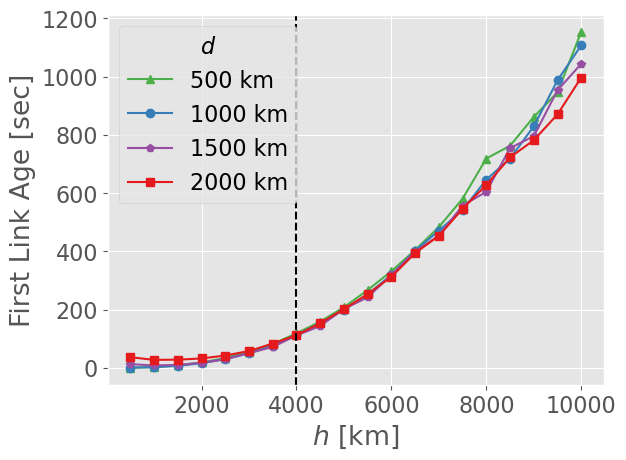

In [109]:
mark = ["^", "o", "p", "s"]
colors = ["#4daf4a", "#377eb8", "#984ea3", "#e41a1c"]
m = 0
for key, val in meanfla.items():
    plt.plot(alt/1000, val, label=f"{(key/1000).astype(int)} km", marker=mark[m], color=colors[m])
    m += 1

plt.axvline(x=4e3, color="black", linestyle="--")

plt.xlabel(r"$h$ [km]")
plt.ylabel("First Link Age [sec]")

plt.legend(title=r'$d$')

# plt.savefig("../figures/fla.pdf", format="pdf", dpi=300, bbox_inches='tight')

plt.show()

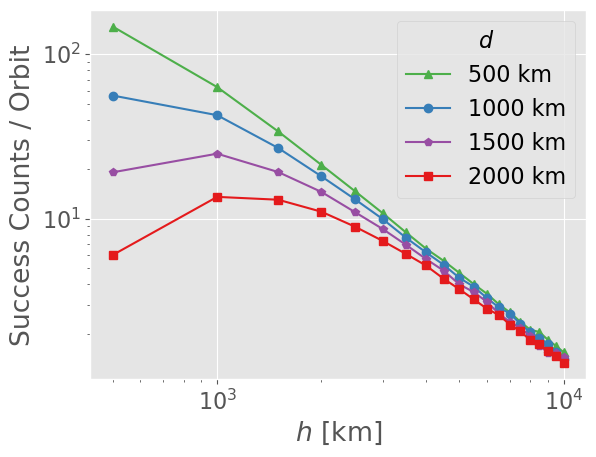

In [ ]:
m = 0
for key, val in meanfla.items():
    plt.loglog(alt/1000, scounts[key], label=f"{(key/1000).astype(int)} km", marker=mark[m], color=colors[m])
    m += 1

plt.xlabel(r"$h$ [km]")
plt.ylabel("Success Counts / Orbit")

plt.legend(title=r'$d$')

# plt.savefig("../figures/success-counts.pdf", format="pdf", dpi=300, bbox_inches='tight')

plt.show()

In [67]:
T = {}

for d in sep:
    T[d] = []
    for h in alt:
        s = sim(h)
        s.initial_conditions(d)
        T[d].append(s.visibility())

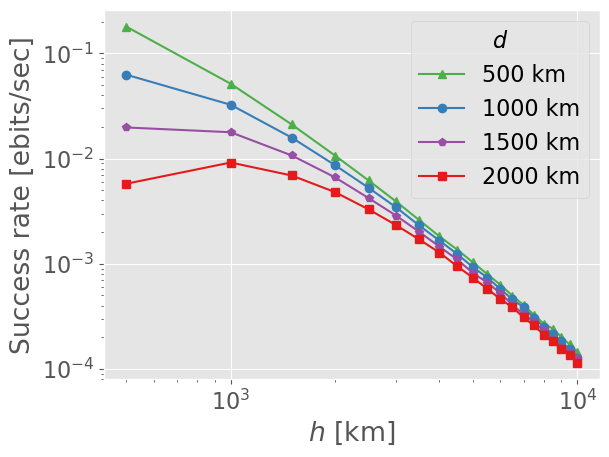

In [ ]:
m = 0
for key, val in meanfla.items():
    plt.loglog(alt/1000, np.array(scounts[key])/np.array(T[key]), label=f"{(key/1000).astype(int)} km", marker=mark[m], color=colors[m])
    m += 1

plt.xlabel(r"$h$ [km]")
plt.ylabel("Success rate [ebits/sec]")

plt.legend(title=r'$d$')

# plt.savefig("../figures/success-rate.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()

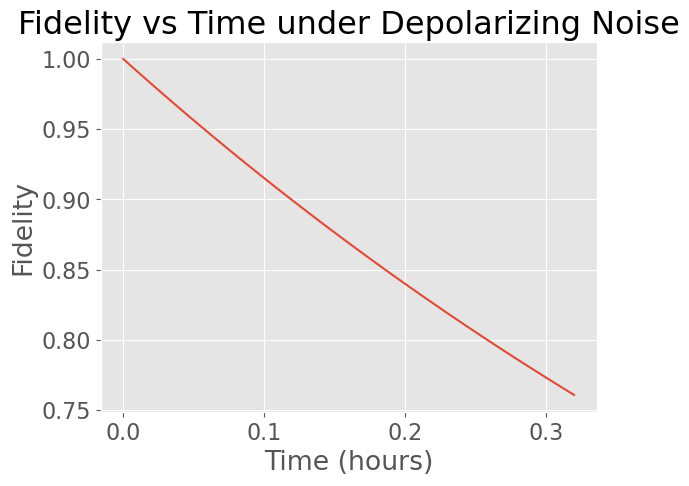

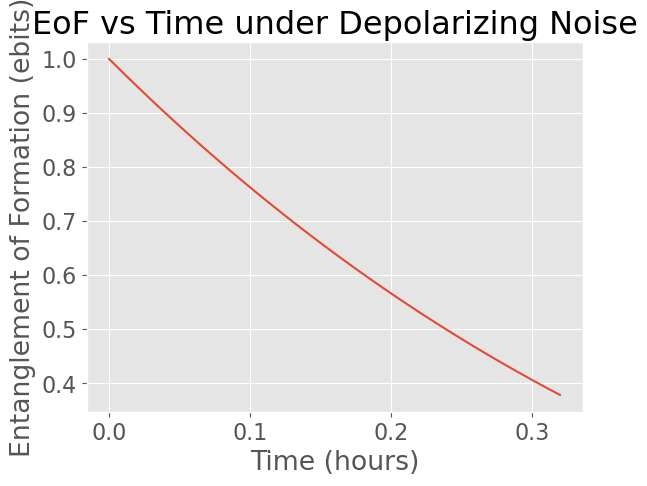

In [114]:
import numpy as np
import math
import matplotlib.pyplot as plt

# Depolarizing parameter
def p(t, gamma):
    return 1 - np.exp(-gamma * t)

# Fidelity with respect to \Phi+
def fidelity(t, gamma):
    p_t = p(t, gamma)
    return (1 - p_t) + p_t / 4

# Concurrence for the two-qubit Werner state
def concurrence(t, gamma):
    F = fidelity(t, gamma)
    return max(0, 2 * F - 1)

# Entanglement of Formation
def entanglement_of_formation(t, gamma):
    C = concurrence(t, gamma)
    if C <= 0:
        return 0.0
    x = (1 + math.sqrt(1 - C**2)) / 2
    return -x * math.log2(x) - (1 - x) * math.log2(1 - x)

# Wrapper to compute all metrics at once
def compute_entanglement(t, gamma=1.0):
    return {
        'time (h)': t,
        'fidelity': fidelity(t, gamma),
        'concurrence': concurrence(t, gamma),
        'EoF (ebits)': entanglement_of_formation(t, gamma)
    }

# Example: compute at a single time
# print(compute_entanglement(0.1, gamma=1.2))

# Plotting fidelity vs time
ts = np.linspace(0, 0.32, 100)
Fs = [fidelity(t, gamma=1.2) for t in ts]
plt.plot(ts, Fs)
plt.xlabel('Time (hours)')
plt.ylabel('Fidelity')
plt.title('Fidelity vs Time under Depolarizing Noise')
plt.show()

# Plotting entanglement of formation vs time
EFs = [entanglement_of_formation(t, gamma=1.2) for t in ts]
plt.plot(ts, EFs)
plt.xlabel('Time (hours)')
plt.ylabel('Entanglement of Formation (ebits)')
plt.title('EoF vs Time under Depolarizing Noise')
plt.show()


In [139]:
fid = {}
eof = {}
g = 0.01

for key, vals in meanfla.items():
    fid[key] = [fidelity(t, gamma=g) for t in vals]
    eof[key] = [entanglement_of_formation(t, gamma=g) for t in vals]

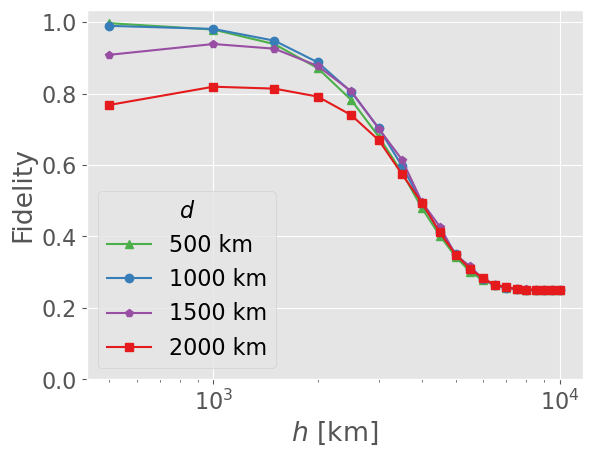

In [ ]:
m = 0
for key, val in meanfla.items():
    plt.semilogx(alt/1000, fid[key], label=f"{(key/1000).astype(int)} km", marker=mark[m], color=colors[m])
    m += 1

plt.xlabel(r"$h$ [km]")
plt.ylabel(r"Fidelity")

plt.ylim(bottom=0)

plt.legend(title=r'$d$')

# plt.savefig("../figures/fidelity.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()

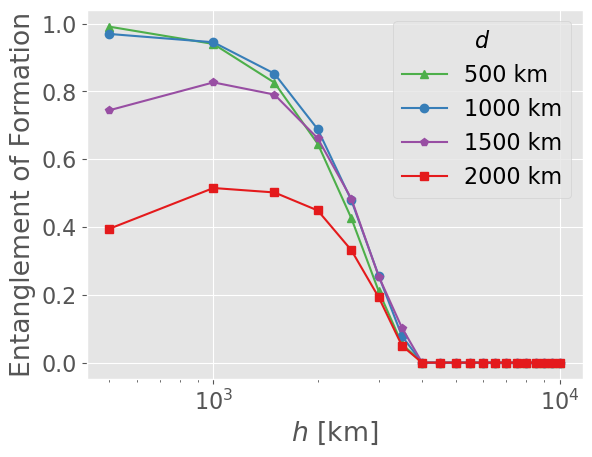

In [ ]:
m = 0
for key, val in meanfla.items():
    plt.semilogx(alt/1000, eof[key], label=f"{(key/1000).astype(int)} km", marker=mark[m], color=colors[m])
    m += 1

plt.xlabel(r"$h$ [km]")
plt.ylabel(r"Entanglement of Formation")

plt.legend(title=r'$d$')

# plt.savefig("../figures/eof.pdf", format="pdf", dpi=300, bbox_inches="tight")

plt.show()

In [41]:
from get_constants import M_E, R_E, G, omega_E

h = np.arange(5e3, 3.575e7)

omega_s = np.sqrt((G*M_E) / ((h + R_E)**3))
ep = 500/(2 * R_E)
theta_0 = np.pi - np.arccos(-(1/(h + R_E)) * (R_E * np.sin(ep) + np.cos(ep) * 
                                      np.sqrt((h + R_E)**2 - R_E**2)))
theta_f = np.pi - theta_0

T_vis = (theta_f - theta_0) / (omega_s - omega_E)

In [42]:
T_vis

array([6.80182165e+01, 6.80250238e+01, 6.80318304e+01, ...,
       3.07022170e+07, 3.07030806e+07, 3.07039443e+07])

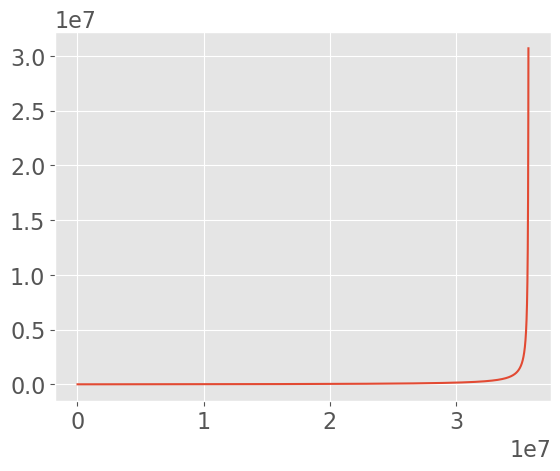

In [44]:
plt.plot(h, T_vis)

In [18]:
# grab the 3rd row (0-based!) of the DataFrame at key 5e5
row3 = fla[5e5].iloc[2]
print(row3)

NameError: name 'fla' is not defined

In [19]:
dist

{500000.0: {}, 1000000.0: {}, 1500000.0: {}, 2000000.0: {}}

In [ ]:
dist = {}

for d in sep:
    dist[d] = {}

,500000.0,1000000.0,1500000.0,2000000.0
statistic,,,,
elapsed_time_mean,818.010236,893.838841,969.665158,1045.492487
elapsed_time_std,0.006270,0.005966,0.005474,0.005517
elapsed_time_stderr,0.000280,0.000267,0.000245,0.000247
success_resets_mean,146.768000,55.990000,19.152000,6.030000
success_resets_std,9.315779,6.216364,3.575817,1.917408
success_resets_stderr,0.416614,0.278004,0.159915,0.085749
success_region_0_mean,30.900000,3.282000,0.146000,0.000000
success_region_0_std,4.639510,1.728714,0.380754,0.000000
success_region_0_stderr,0.207485,0.077310,0.017028,0.000000


In [28]:
fla = pd.read_csv("data/first-link-age.csv")
times = pd.read_csv("data/success-times-counts.csv")

cutoff_times = fla["cutoff_time"]

fla = fla.drop(columns='cutoff_time')
times = times.drop(columns='cutoff_time')

ages = [row.dropna().tolist() for _, row in fla.iterrows()]
bins = [row.dropna().tolist() for _, row in times.iterrows()]

age = ages[-1]
bin = bins[-1]

In [48]:
from collections import defaultdict

grouped = defaultdict(list)

for a, b in zip(age, bin):
    grouped[b].append(a)

grouped = dict(grouped)

bin_values = np.array(list(grouped.keys()))
values = list(grouped.values())

means     = np.array([np.mean(v) for v in values])
means_std = np.array([np.std(v)  for v in values])

# sort by bin so the line is monotonic
order = np.argsort(bin_values)
b_sorted     = bin_values[order]
means_sorted = means[order]
std_sorted   = means_std[order]

x = np.repeat(bin_values, [len(v) for v in values])
y = np.concatenate(values)

xy = np.vstack([x, y]).astype(np.float64)

In [43]:
kde = gaussian_kde(xy)
density = kde(xy)

In [58]:
E = [0.4690739205456245,
 0.4660368202222881,
 0.4663810185704533,
 0.4633074227361888,
 0.4635512392101775,
 0.4637271277786884,
 0.4605829722998217,
 0.46065649116670604,
 0.4574746609530233,
 0.4574446695541372,
 0.4573446004117478,
 0.4540902210442385,
 0.45388477059549026,
 0.4536079531604263,
 0.4502799726791746,
 0.4498960421207703,
 0.4494395373612318,
 0.4460371773375524,
 0.4454720367243046,
 0.444833239387812,
 0.4413560920002655,
 0.4406074302967757,
 0.4397842058164921,
 0.43623235050884523,
 0.43529842956336656,
 0.4342892781172554,
 0.4306634197199498,
 0.42954325687918476,
 0.42834750682964046,
 0.4246491364221667,
 0.42334271742075075,
 0.4219607493578983,
 0.4181923281257553,
 0.4167008505077346,
 0.4151343515129,
 0.4134930698562998,
 0.40962566157015184,
 0.4078779069777228,
 0.40605672779879787,
 0.4021299238950544,
 0.40020608065874197,
 0.3982109175823509,
 0.3961452967100106,
 0.39213947127857507,
 0.3899785593059116,
 0.3877504896310768,
 0.3854565867769244,
 0.38138967833859044,
 0.379011031863651,
 0.376571244646746,
 0.3724821887217233,
 0.36996783150427826,
 0.36739815169333534,
 0.36477542114005224,
 0.3606705178484776,
 0.3579901735210067,
 0.35526420231975453,
 0.3524954597466212,
 0.3484092672385354,
 0.3456037497885669,
 0.3427644794588476,
 0.338726323114437,
 0.3358680916882974,
 0.3329862071425982,
 0.3290205698952161,
 0.32613928683293125,
 0.3232453866005235,
 0.31937850446291005,
 0.3165061828286363,
 0.3136330115876793,
 0.30989234952280736,
 0.30706271472691926,
 0.3042444741873423,
 0.30065809632669444,
 0.2979058212434486,
 0.29517737032402974,
 0.29177324575116953,
 0.28913311079631193,
 0.28587219897122307,
 0.2833344102842007,
 0.280227407535909,
 0.2778055565809986,
 0.2748626383411936,
 0.27256975777811826,
 0.26980049500214703,
 0.2676489580584432,
 0.2650622527305475,
 0.26306369497658083,
 0.2606677364066411,
 0.25883300176465385,
 0.25663524423777967,
 0.2545443296198824,
 0.25298151692069115,
 0.2510979571880938,
 0.24932446996039218,
 0.24805122033260266,
 0.24649273380403378,
 0.24504687932174873,
 0.24407839677309295,
 0.24285382784568338,
 0.2417438643425597,
 0.2407488706494452,
 0.23986916466006433,
 0.23944211362858692,
 0.23879094058922964,
 0.2382562680610442,
 0.23783824811728935,
 0.2375369978638041,
 0.23735260072051795,
 0.23728510735670613,
 0.23733453626836507,
 0.23750087399039876,
 0.2377840749412205,
 0.23818406090156347,
 0.23870072013411406,
 0.23933390615433803,
 0.23974355395803376,
 0.24060542477937577,
 0.24158262915167164,
 0.24267485621472001,
 0.24388174903751442,
 0.2448336005132056,
 0.24626201158581315,
 0.24780314155604902,
 0.24945641075001465,
 0.25081680968861303,
 0.25268342571341157,
 0.25465944948909164,
 0.25630530565339144,
 0.25848663829647717,
 0.26030696557486366,
 0.26268694271366283,
 0.26467177854410234,
 0.2672430002925572,
 0.26991402736375186,
 0.2721358917551457,
 0.2749864152826047,
 0.2773451893283282,
 0.27975572270275645,
 0.2828490511187356,
 0.28537642597650764,
 0.28862436063694574,
 0.29125502563788397,
 0.2946469081089569,
 0.29736686433837306,
 0.3001111981512891,
 0.3036865430718368,
 0.3064978442047909,
 0.3101881778675733,
 0.31305197046005495,
 0.3159197628876139,
 0.3197475429864897,
 0.3226455940730361,
 0.32553564286189113,
 0.3294730537344114,
 0.3323719142657334,
 0.33525140626714967,
 0.3381077361084071,
 0.34213973345884935,
 0.3449779720885117,
 0.3477829064912243,
 0.35186402489662494,
 0.3546329761359445,
 0.35735955653175516,
 0.36004089221109387,
 0.364142034191237,
 0.3667664279246296,
 0.36933810146164475,
 0.3734395243553159,
 0.3759411735290145,
 0.37838381402206517,
 0.38076557478936846,
 0.3848305344053083,
 0.3871280106714248,
 0.3893598664967679,
 0.39152476097469263,
 0.3955294098620977,
 0.39759936097903564,
 0.3995990077752868,
 0.40355490471179306,
 0.4054536977425135,
 0.4027388275197048,
 0.40081955113675116,
 0.39882881567734346,
 0.3967674691503558,
 0.3927603808330039,
 0.39060339666981986,
 0.3883790589512014,
 0.384332228991815,
 0.3820197366978773,
 0.37964415281269437,
 0.37720716804425936,
 0.3731153874933502,
 0.37060328734715753,
 0.36803555383547953,
 0.3654144401972665,
 0.3613057034780161,
 0.3586263069315406,
 0.35590090263420643,
 0.35180967924993894,
 0.34904099511725345,
 0.34623485640990526,
 0.3433945174533073,
 0.3393501405188946,
 0.3364899731706404,
 0.33360566288912724,
 0.3296326458079918,
 0.32674800500570395,
 0.32385022321867213,
 0.31997474538702847,
 0.31709756385785137,
 0.3142189858197006,
 0.3104684829740013,
 0.30763243894399966,
 0.3048072319623801,
 0.30120977001433163,
 0.2984495266204959,
 0.2949769946841533,
 0.29229613577627794,
 0.28964650263407465,
 0.286372561944932,
 0.283824329837326,
 0.28070360012809903,
 0.27827040019410826,
 0.2753131006175216,
 0.2730080126820474,
 0.2702237628261333,
 0.2680592132207802,
 0.26545696714516887,
 0.2634446487690349,
 0.26103264976505697,
 0.25918346631091854,
 0.25696922303178077,
 0.2548616690918267,
 0.2532835414327206,
 0.2513829746046092,
 0.24959236171626276,
 0.248303055991888,
 0.24672714720016475,
 0.24526378300308765,
 0.24427861707859294,
 0.24303630427188047,
 0.2419085360139685,
 0.24089568415213478,
 0.2399980736147307,
 0.23921598508168765,
 0.23888433176611196,
 0.23833157470502095,
 0.2378954489645539,
 0.2375760769827424,
 0.23737354733532676,
 0.2372879157254841,
 0.2373192056173443,
 0.23746740850507014,
 0.2377324838145556,
 0.2381143584386303,
 0.23861292591181313,
 0.23922804523433952,
 0.23962019699253828,
 0.24046415016703535,
 0.24142348116141762,
 0.2424978860238557,
 0.24368701514966082,
 0.24462213384902626,
 0.24603300978802148,
 0.24755668924682792,
 0.24919260180771663,
 0.2505370810543251,
 0.25238665190748305,
 0.25434575646886276,
 0.25597646059839124,
 0.2581412584119709,
 0.25994705263535334,
 0.26231093234489217,
 0.2647780703396176,
 0.2668375303932564,
 0.26949316497851195,
 0.2717022472280971,
 0.2745379495741467,
 0.276884765152736,
 0.279891403049231,
 0.28236334515925593,
 0.2848801517409075,
 0.28811496324417313,
 0.2907359994241397,
 0.29411548879787336,
 0.29682678781161353,
 0.2995630166636132,
 0.3031271716129925,
 0.3059313673541958,
 0.3096113021962808,
 0.31246899533150074,
 0.31533124176622973,
 0.3191498721854645,
 0.3220433698678927,
 0.3249294011115534,
 0.3288588956436929,
 0.33175469432556426,
 0.33463163088460834,
 0.33864511906289946,
 0.3415115731189773,
 0.3443486222153305,
 0.34715281821986455,
 0.35122870156107555,
 0.35399771022031595,
 0.35672475148620264,
 0.3608283186779233,
 0.36350415828159643,
 0.3661300749173381,
 0.36870360520644063,
 0.3728019618323958,
 0.3753060536365605,
 0.37775141929248757,
 0.38183419352550635,
 0.3841990367466724,
 0.38649996743085774,
 0.38873549390690604,
 0.39276427848519196,
 0.39490759498552547,
 0.39698176994083084,
 0.39898579746293583,
 0.40294084805219826,
 0.40484430184015746,
 0.4066751339555196,
 0.41057374323506424,
 0.41229956771434473,
 0.41395109450120404,
 0.41552798475836383,
 0.41933036966828535,
 0.4207985132131997,
 0.4221912421398809,
 0.4259249643824876,
 0.4272073685412908,
 0.4284141150663954,
 0.4320762180359957,
 0.4331719559549146,
 0.434192229073568,
 0.4351372732155144,
 0.43869012264818735,
 0.4395245047201392,
 0.44028429910864936,
 0.4437625791702409,
 0.4444124992675129,
 0.44498871730142314,
 0.44839229445980205,
 0.4488598323297147,
 0.4492547353099018,
 0.4525839746185856,
 0.45287169416227013,
 0.456162125075396,
 0.4563436215931594,
 0.4564544317042182,
 0.45967175940396365,
 0.4596781653693377,
 0.45961520539698414,
 0.46276060084360127,
 0.4625951619365028,
 0.4657032530010742,
 0.46543649926234226,
 0.4651025488056565,
 0.4681408183671435,
 0.4677075547519706,
 0.47070975810248017,
 0.4701783703705171,
 0.4695819502879965,
 0.4725166542792697,
 0.4718240962994567,
 0.474724067891754,
 0.4739365377942526,
 0.4768022652290731,
 0.47592091246537677,
 0.4749773828130755,
 0.4777788382540898,
 0.47674336031800824]

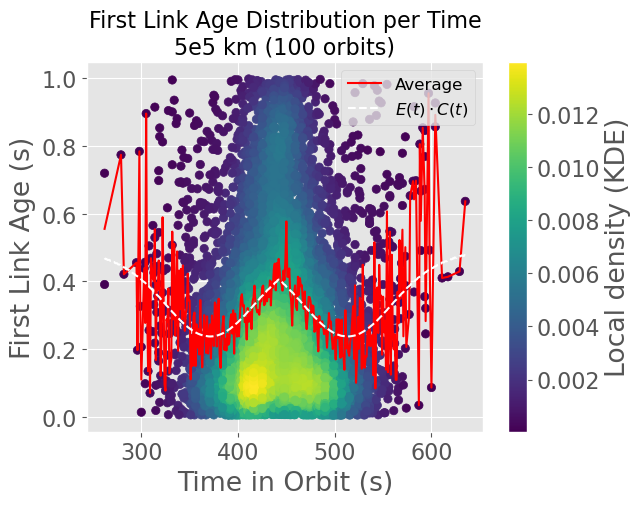

In [63]:
plt.figure()
plt.scatter(x, y, c=density, cmap='viridis')
plt.colorbar(label='Local density (KDE)')
# plt.errorbar(cutoff_times, means, yerr=means_std, color='red', label='Average')
plt.plot(b_sorted, means_sorted, label='Average', color='red')
plt.plot(np.arange(262, 636, 1), E, label=r'$E(t) \cdot C(t)$', color='white', linestyle='--')
# plt.plot(cutoff_times, cutoff_times/2, color='pink', linestyle='--', label=r'$\frac{x}{2}$')

plt.xlabel('Time in Orbit (s)')
plt.ylabel('First Link Age (s)')
title = r"First Link Age Distribution per Time" + "\n5e5 km (100 orbits)"
plt.title(title, fontsize=size)

plt.legend(fontsize=size-4, loc='best')
# plt.xlim(0, 886)

plt.savefig('data/figures/fla-time-dist.pdf', dpi=300, bbox_inches='tight')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


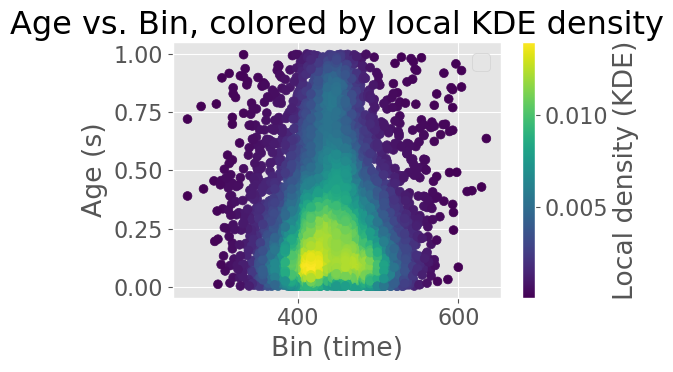

In [37]:
# 2) flatten into x, y arrays
bin_values = np.array(list(grouped.keys()))
values    = list(grouped.values())

# x: repeat each bin value for as many ages as it has
x = np.repeat(bin_values, [len(v) for v in values])

# y: concatenate all the age‐lists
y = np.concatenate(values)

# 3) compute 2D KDE over (x,y)
xy = np.vstack([x, y])            # shape (2, N)
kde = gaussian_kde(xy)            # fit
density = kde(xy)                 # evaluate at each (x,y)

# 4) scatter with density coloring
plt.figure(figsize=(6,4))
plt.scatter(x, y, c=density, cmap='viridis', s=40)

cbar = plt.colorbar()
cbar.set_label('Local density (KDE)')

# 5) if you also want to overlay the group means (and ±1σ)
means     = np.array([np.mean(v) for v in values])
means_std = np.array([np.std(v)  for v in values])

# sort by bin so the line is monotonic
order = np.argsort(bin_values)
b_sorted     = bin_values[order]
means_sorted = means[order]
std_sorted   = means_std[order]

# plt.errorbar(b_sorted, means_sorted,
#              yerr=std_sorted,
#              fmt='-o', color='red',
#              label='Mean ±1σ')

# 6) labels & legend
plt.xlabel('Bin (time)')
plt.ylabel('Age (s)')
plt.title('Age vs. Bin, colored by local KDE density')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
values = [
    row.dropna().tolist()
    for _, row in fla.iterrows()
]
means = [np.mean(row) for row in values]
means_std = [np.std(row, ddof=1) for row in values]
means_std_err = [np.std(row, ddof=1) / np.sqrt(len(row)) for row in values]

In [20]:
means[-1] / means[0]

1.4506031900356697

In [71]:
values = [
    [v for v in row.dropna() if v <= 2]
    for _, row in fla.iterrows()
]

x = np.repeat(alpha, [len(row) for row in values])
y = np.concatenate(values)

In [ ]:
xy = np.vstack([x, y]).astype(np.float64)

In [40]:
kde = gaussian_kde(xy)
density = kde(xy)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


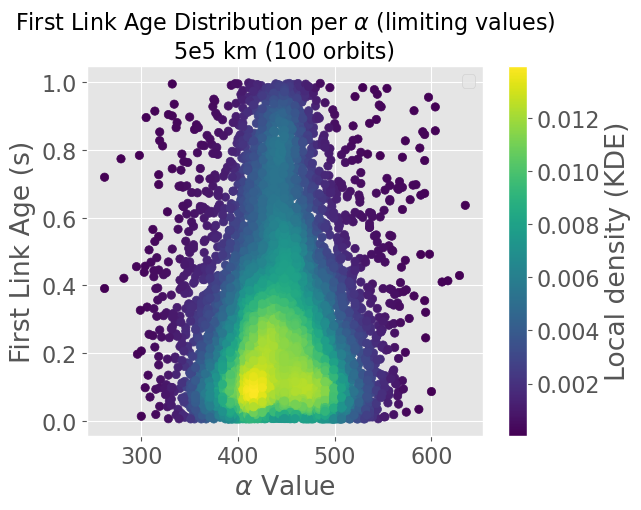

In [42]:
plt.figure()
plt.scatter(x, y, c=density, cmap='viridis')
plt.colorbar(label='Local density (KDE)')
# plt.errorbar(cutoff_times, means, yerr=means_std, color='red', label='Average')
# plt.plot(bin_values, means, label='Average', color='red')
# plt.plot(cutoff_times, cutoff_times/2, color='pink', linestyle='--', label=r'$\frac{x}{2}$')

plt.xlabel(r'$\alpha$ Value')
plt.ylabel('First Link Age (s)')
title = r"First Link Age Distribution per $\alpha$ (limiting values)" + "\n5e5 km (100 orbits)"
plt.title(title, fontsize=size)

plt.legend(fontsize=size-4, loc='best')

# plt.savefig('data/figures/alpha-less-than-2-prob-dist.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [47]:
times = pd.read_csv("data/alpha-success-times-counts.csv")
alpha = times['cutoff_time']
times = times.drop(columns='cutoff_time')

In [48]:
times

,0,1,2,3,4,5,6,7,8,9,...,5331,5332,5333,5334,5335,5336,5337,5338,5339,5340
0,337.0,363.0,369.0,373.0,376.0,380.0,387.0,392.0,396.0,397.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,272.0,281.0,391.0,407.0,409.0,412.0,418.0,423.0,425.0,425.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,316.0,373.0,394.0,396.0,413.0,414.0,419.0,423.0,428.0,430.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,320.0,330.0,351.0,361.0,364.0,373.0,378.0,380.0,387.0,401.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,348.0,353.0,360.0,370.0,381.0,393.0,397.0,404.0,406.0,407.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,314.0,345.0,346.0,363.0,376.0,399.0,402.0,404.0,415.0,421.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,309.0,350.0,370.0,387.0,389.0,390.0,396.0,412.0,413.0,414.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,323.0,344.0,355.0,371.0,396.0,397.0,398.0,401.0,403.0,406.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,288.0,360.0,372.0,375.0,381.0,396.0,400.0,402.0,404.0,408.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,286.0,372.0,377.0,387.0,392.0,408.0,411.0,411.0,413.0,414.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
values = [
    row.dropna().tolist()
    for _, row in times.iterrows()
]
means = [np.mean(row) for row in values]
means_std = [np.std(row, ddof=1) for row in values]
means_stderr = [np.std(row, ddof=1) / np.sqrt(len(row)) for row in values]

In [51]:
x = np.repeat(alpha, [len(row) for row in values])
y = np.concatenate(values)
xy = np.vstack([x, y]).astype(np.float64)

In [52]:
kde = gaussian_kde(xy)
density = kde(xy)

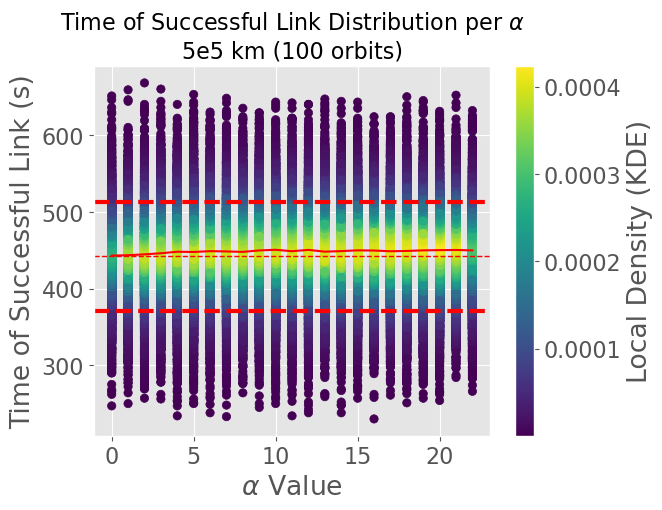

In [ ]:
plt.figure()
plt.scatter(x, y, c=density, cmap='viridis')
plt.colorbar(label='Local Density (KDE)')
plt.plot(alpha, means, label='Average', color='red')
plt.axhline(y=442.155138067, color='red', linestyle='--', linewidth=1)
plt.axhline(y=371.077569033, color='red', linestyle='--', linewidth=3)
plt.axhline(y=513.2327071, color='red', linestyle='--', linewidth=3)

plt.xlabel(r'$\alpha$ Value')
plt.ylabel('Time of Successful Link (s)')
title = r"Time of Successful Link Distribution per $\alpha$" + "\n5e5 km (100 orbits)"
plt.title(title, fontsize=size)

# plt.legend(fontsize=size-4, loc='best')

# plt.savefig('data/figures/alpha-success-times-dist.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [2]:
data = pd.read_csv("data/alpha-success-times-counts.csv")

In [3]:
import numpy as np
epsilon = 0.073485271681
G = 6.6743e-11
ME = 5.9722e24
RE = 6.3781e6
omegaE = 7.2921e-5

r = RE + 5e5
omegaS = np.sqrt( (G * ME) / r**3)

theta0 = np.pi - np.arccos( -(1 / r) * (
    RE * np.sin(epsilon) + np.cos(epsilon) * np.sqrt(
        r**2 - RE**2
    )
))
theta_leaving = np.arccos( (1 / r) * (
    RE * np.sin(epsilon) - np.cos(epsilon) * np.sqrt(
        r**2 - RE**2
    )
))
theta_entering = np.pi - theta_leaving
thetaf = np.pi - theta0
phi0 = (np.pi / 2) - epsilon
phi1 = (np.pi / 2) + epsilon

t1 = (phi0 - theta0) / (omegaS - omegaE)
t2 = (phi1 - theta0) / (omegaS - omegaE)
tentering = (theta_entering - theta0) / (omegaS - omegaE)
tleaving = (theta_leaving - theta0) / (omegaS - omegaE)
twhole = (thetaf - theta0) / (omegaS - omegaE)

tentering, t1, t2, tleaving, twhole

(142.15513806675824,
 371.07756903337724,
 513.2327071001355,
 742.1551380667545,
 884.3102761335127)

In [4]:
from collections import Counter, OrderedDict

counts_dict = {
    alpha: Counter(row.dropna().astype(int))
    for alpha, row in data.set_index("cutoff_time").iterrows()
}

full_times = range(0, 886)   # 0, 1, 2, …, 885

filled_counts = {
    alpha: OrderedDict(
        (t, counter.get(t, 0))
        for t in full_times
    )
    for alpha, counter in counts_dict.items()
}

# e.g. for alpha=0
print(filled_counts[0])
# Counter({337: 1, 363: 1, 369: 1, …})

OrderedDict([(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 0), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 0), (37, 0), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0), (60, 0), (61, 0), (62, 0), (63, 0), (64, 0), (65, 0), (66, 0), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 0), (83, 0), (84, 0), (85, 0), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 0), (97, 0), (98, 0), (99, 0), (100, 0), (101, 0), (102, 0), (103, 0), (104, 0), (105, 0), (106, 0), (107, 0), (108, 0), (109, 0

C:\Users\agflo\AppData\Local\Temp\ipykernel_20516\3419937334.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap   = cm.get_cmap('jet')


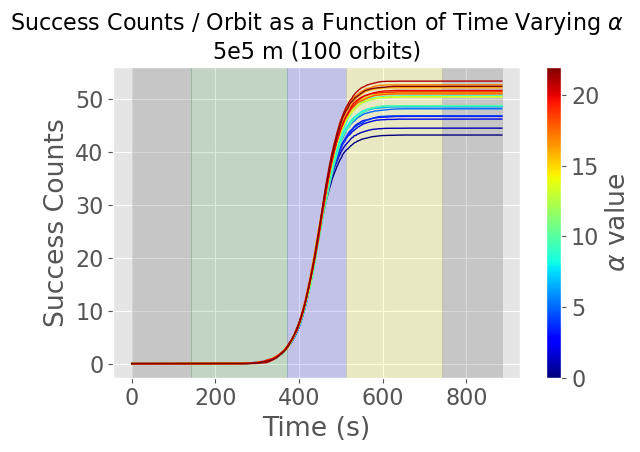

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

df_counts = pd.DataFrame(filled_counts)

# 5. Compute cumulative sum over time
df_cum = df_counts.cumsum()

# your existing df_cum and alphas setup...
alphas = df_cum.columns.values.astype(float)
norm   = mcolors.Normalize(vmin=alphas.min(), vmax=alphas.max())
cmap   = cm.get_cmap('jet')

# 1) create figure and axes
fig, ax = plt.subplots()

plt.axvspan(0, tentering, color='gray', alpha=0.3)
plt.axvspan(tentering, t1, color='green', alpha=0.15)
plt.axvspan(t1, t2, color='blue', alpha=0.15)
plt.axvspan(t2, tleaving, color='yellow', alpha=0.15)
plt.axvspan(tleaving, twhole, color='gray', alpha=0.3)

# 2) plot each α‐line into ax
for alpha in alphas:
    ax.plot(df_cum.index,
            df_cum[alpha] / 100,    # or whatever scaling you’ve applied
            color=cmap(norm(alpha)),
            linewidth=1)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Success Counts')
title = r'Success Counts / Orbit as a Function of Time Varying $\alpha$' + "\n5e5 m (100 orbits)"
ax.set_title(title, fontsize=size)

# 3) make the ScalarMappable and attach the colorbar to ax
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])   # no real data array needed for the colorbar

# pass ax to colorbar so it knows where to draw it
fig.colorbar(sm, ax=ax, label=r'$\alpha$ value')

# plt.ylim(50, 54)
# plt.xlim(500, 890)

plt.tight_layout()

# plt.savefig("data/figures/success-counts-alpha.pdf", dpi=300, bbox_inches='tight')
plt.show()

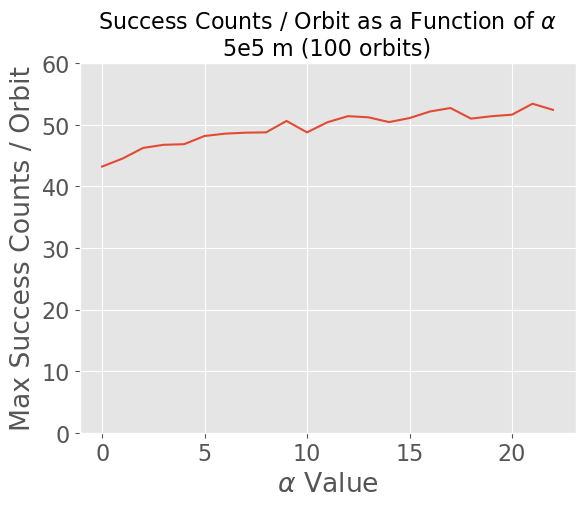

In [ ]:
d_max = [np.max(arr)/100 for _, arr in df_cum.items()]

plt.plot(alphas, d_max)

title = r"Success Counts / Orbit as a Function of $\alpha$" + "\n5e5 m (100 orbits)"
plt.title(title, fontsize=size)
plt.xlabel(r'$\alpha$ Value')
plt.ylabel('Max Success Counts / Orbit')

plt.ylim(0, 60)

# plt.savefig("data/figures/max-success-counts-alpha.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [15]:
d_max

[4321,
 4451,
 4623,
 4674,
 4684,
 4817,
 4855,
 4871,
 4876,
 5061,
 4876,
 5041,
 5139,
 5120,
 5043,
 5108,
 5215,
 5271,
 5099,
 5138,
 5163,
 5341,
 5241]

In [10]:
stats = pd.read_csv("data/alpha-stats.csv")
alpha = stats['cutoff_time']

In [16]:
np.max(stats[s + "1" + m]) / np.min(stats[s + "1" + m])

1.209767814251401

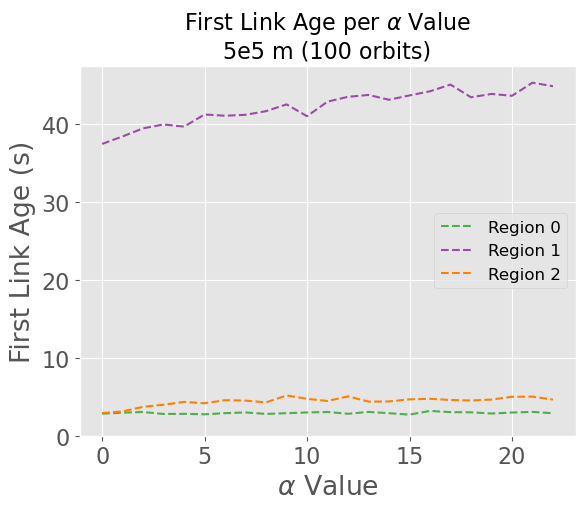

In [13]:
info = "success_resets" + "_mean"
s = "success_region_"
m = "_mean"

# plt.plot(alpha, means, color='#e41a1c', label='All Regions')
plt.plot(alpha, stats[s + "0" + m], color='#4daf4a', label='Region 0', linestyle='--')
plt.plot(alpha, stats[s + "1" + m], color='#984ea3', label='Region 1', linestyle='--')
plt.plot(alpha, stats[s + "2" + m], color='#ff7f00', label='Region 2', linestyle='--')

title = r"First Link Age per $\alpha$ Value" + "\n5e5 m (100 orbits)"
plt.title(title, fontsize=size)
plt.xlabel(r'$\alpha$ Value')
plt.ylabel('First Link Age (s)')

plt.ylim(bottom=0)

plt.legend(fontsize=size-4, loc='best')

# plt.savefig("data/figures/alpha-first-link-age.pdf", dpi=300, bbox_inches='tight')

plt.show()

In [ ]:
# plt.figure(dpi=300)

# plt.plot(all_times, fixed_gen["counts"], label="Fixed Cutoff - Generous", color="#ffff33")
plt.plot(all_times, fixed["counts"], label="Fixed Cutoff", color="#4daf4a")
# plt.plot(all_times, dynamic_gen["counts"], label="Dynamic Cutoff - Generous", color="#984ea3")
plt.plot(all_times, dynamic["counts"], label="Dynamic Cutoff", color="#377eb8")
# plt.plot(all_times, regions_gen["counts"], label="Regional Cutoff - Generous", color="#ff7f00")
plt.plot(all_times, regions["counts"], label="Regional Cutoff", color="#e41a1c")

plt.axvspan(0, tentering, color='gray', alpha=0.3)
plt.axvspan(tentering, t1, color='green', alpha=0.15)
plt.axvspan(t1, t2, color='blue', alpha=0.15)
plt.axvspan(t2, tleaving, color='yellow', alpha=0.15)
plt.axvspan(tleaving, twhole, color='gray', alpha=0.3)

plt.title("Comparing Greedy Cutoff Protocols (2000 orbits)", fontsize=size)
plt.xlabel("Time (s)")
plt.ylabel("Success Counts per Time")

plt.legend(fontsize=size-4, loc='best', bbox_to_anchor=(0.55, 0.5))

# pdf_path = "data/figures/greedy-cutoff-protocols.pdf"
# plt.savefig(pdf_path, bbox_inches='tight')

plt.show()

In [ ]:
info = "success_resets"

plt.figure(dpi=300)

# plt.yscale('log')
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.plot(cutoff_values, random[f"{info}" + "_mean"] / t_array,
         label="Random Selection", color="#c6c6c6")

plt.plot(cutoff_values, furthest[f"{info}" + "_mean"] / t_array,
            #  yerr=furthest[f"{info}_errors"],
             label="Furthest First", color="#377eb8")

plt.plot(cutoff_values, station2f[f"{info}" + "_mean"] / t_array,
            #  yerr=station2f[f"{info}_errors"],
             label="GS 2 First", color="#984ea3")

plt.plot(cutoff_values, closest[f"{info}" + "_mean"] / t_array,
            #  yerr=closest[f"{info}_errors"],
             label="Closest First", color="#e41a1c")

plt.plot(cutoff_values, station1f[f"{info}" + "_mean"] / t_array,
            #  yerr=station1f[f"{info}_errors"],
             label="GS 1 First", color="#ff7f00")

plt.title(f"Success Rate as a Function of Cutoff Time\n{tit}, {t:.3g} s, {alt} m, 100 orbits", fontsize=size)

plt.xlabel("Cutoff Time (s)")
plt.ylabel("Counts")

# plt.legend(fontsize=size-6, loc='best', bbox_to_anchor=(1, 0.6))
plt.legend(fontsize=size-4)

pdf_path = f"data/figures/{info}-scaled-{alt}-{region}.pdf"
plt.savefig(pdf_path, bbox_inches='tight')

plt.show()

### Plotting Failure Counts

In [ ]:
info = "cutoff_resets"

plt.figure(dpi=300)

# plt.yscale('log')
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.plot(cutoff_values, random[f"{info}" + "_mean"],
         label="Random Selection", color="#c6c6c6")

plt.plot(cutoff_values, furthest[f"{info}" + "_mean"],
            #  yerr=furthest[f"{info}_errors"],
             label="Furthest First", color="#377eb8")

plt.plot(cutoff_values, station2f[f"{info}" + "_mean"],
            #  yerr=station2f[f"{info}_errors"],
             label="GS 2 First", color="#984ea3")

plt.plot(cutoff_values, closest[f"{info}" + "_mean"],
            #  yerr=closest[f"{info}_errors"],
             label="Closest First", color="#e41a1c")

plt.plot(cutoff_values, station1f[f"{info}" + "_mean"],
            #  yerr=station1f[f"{info}_errors"],
             label="GS 1 First", color="#ff7f00")

plt.ylim(bottom=0)

plt.title(f"Failure Counts as a Function of Cutoff Time\n{tit}, {alt} m, 100 orbits", fontsize=size)

plt.xlabel("Cutoff Time (s)")
plt.ylabel("Counts")

plt.legend(fontsize=size-4)

pdf_path = f"data/figures/{info}-{alt}-{region}.pdf"
plt.savefig(pdf_path, bbox_inches='tight')

plt.show()

### Plotting First Link Age

In [ ]:
info = "second_station_times"

plt.figure(dpi=300)

plt.plot(cutoff_values, random[f"{info}" + "_mean"],
         label="Random Selection", color="#c6c6c6")

plt.plot(cutoff_values, furthest[f"{info}" + "_mean"],
            #  yerr=furthest[f"{info}_errors"],
             label="Furthest First", color="#377eb8")

plt.plot(cutoff_values, station2f[f"{info}" + "_mean"],
            #  yerr=station2f[f"{info}_errors"],
             label="GS 2 First", color="#984ea3")

plt.plot(cutoff_values, closest[f"{info}" + "_mean"],
            #  yerr=closest[f"{info}_errors"],
             label="Closest First", color="#e41a1c")

plt.plot(cutoff_values, station1f[f"{info}" + "_mean"],
            #  yerr=station1f[f"{info}_errors"],
             label="GS 1 First", color="#ff7f00")

plt.ylim(bottom=0)

plt.title(f"First Link Age Upon Success\n{tit}, {alt} m, 100 orbits", fontsize=size)

plt.xlabel("Cutoff Time (s)")
plt.ylabel("Age (s)")

plt.legend(fontsize=size-4)

pdf_path = f"data/figures/{info}-{alt}-{region}.pdf"
plt.savefig(pdf_path, bbox_inches='tight')

plt.show()

### Second Station Attempts

In [ ]:
info = "second_station_attempts"

# rall_low = 

plt.figure(dpi=300)

plt.plot(cutoff_values, random[f"{info}" + "_mean"],
         label="Random Selection", color="#c6c6c6")

plt.plot(cutoff_values, furthest[f"{info}" + "_mean"],
            #  yerr=furthest[f"{info}_errors"],
             label="Furthest First", color="#377eb8")

plt.plot(cutoff_values, station2f[f"{info}" + "_mean"],
            #  yerr=station2f[f"{info}_errors"],
             label="GS 2 First", color="#984ea3")

plt.plot(cutoff_values, closest[f"{info}" + "_mean"],
            #  yerr=closest[f"{info}_errors"],
             label="Closest First", color="#e41a1c")

plt.plot(cutoff_values, station1f[f"{info}" + "_mean"],
            #  yerr=station1f[f"{info}_errors"],
             label="GS 1 First", color="#ff7f00")

plt.ylim(bottom=0)

plt.title(f"# of Attempts to Link with Second Station\n{tit}, {alt} m, 100 orbits", fontsize=size)

plt.xlabel("Cutoff Time (s)")
plt.ylabel("Attempts")

plt.legend(fontsize=size-4)

pdf_path = f"data/figures/{info}-{alt}-{region}.pdf"
plt.savefig(pdf_path, bbox_inches='tight')

plt.show()

### First Station Attempts

In [ ]:
info = "first_station_attempts"

plt.figure(dpi=300)

plt.plot(cutoff_values, random[f"{info}" + "_mean"],
         label="Random Selection", color="#c6c6c6")

plt.plot(cutoff_values, furthest[f"{info}" + "_mean"],
            #  yerr=furthest[f"{info}_errors"],
             label="Furthest First", color="#377eb8")

plt.plot(cutoff_values, station2f[f"{info}" + "_mean"],
            #  yerr=station2f[f"{info}_errors"],
             label="GS 2 First", color="#984ea3")

plt.plot(cutoff_values, closest[f"{info}" + "_mean"],
            #  yerr=closest[f"{info}_errors"],
             label="Closest First", color="#e41a1c")

plt.plot(cutoff_values, station1f[f"{info}" + "_mean"],
            #  yerr=station1f[f"{info}_errors"],
             label="GS 1 First", color="#ff7f00")

plt.ylim(bottom=0)

plt.title(f"# of Attempts to Link with First Station\n{tit}, {alt} m, 100 orbits", fontsize=size)

plt.xlabel("Cutoff Time (s)")
plt.ylabel("Attempts")

plt.legend(fontsize=size-4)

pdf_path = f"data/figures/{info}-{alt}-{region}.pdf"
plt.savefig(pdf_path, bbox_inches='tight')

plt.show()